# Stock Valuation

This project aims to create a portfolio of stocks to buy. The priority is not to pick winning stocks, but to avoid picking losing stocks. I will aim to do this by assessing the value, growth, income and momentum of the companies in the US and UK stock market, and make a portfolio of these companies. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import requests
from IPython.display import display, clear_output
import time
from datetime import datetime, timedelta
import logging

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [2]:
# Example stock symbol
stock_symbol = 'RR.L'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
ebitda = info.get('ebitda', None)
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
trailing_eps = info.get('trailingEps', None)  # Trailing 12-month EPS
forward_eps = info.get('forwardEps', None) 
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA
beta = info.get('beta', None)

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"EBITDA: {ebitda}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Trailing EPS: {trailing_eps}")
print(f"Forward EPS: {forward_eps}")
print(f"Price to Book Ratio: {price_to_book}")
#print(f"Enterprise to Revenue: {enterprise_to_revenue}")
#print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print(f"Beta: {beta}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

Stock: RR.L
EBITDA: 2320000000
P/E Ratio: 1481.7242
Forward P/E Ratio: 23.571037
PEG Ratio: 0.51
Trailing EPS: 0.29
Forward EPS: 18.23
Price to Book Ratio: None
Beta: 1.768

Cash Flow Statement (Annual):
                                         2023-12-31    2022-12-31  \
Free Cash Flow                         1772000000.0   928000000.0   
Repurchase Of Capital Stock              -1000000.0    -1000000.0   
Repayment Of Debt                        -1000000.0 -2024000000.0   
Issuance Of Debt                          2000000.0     1000000.0   
Issuance Of Capital Stock                       NaN           NaN   
Capital Expenditure                    -713000000.0  -596000000.0   
End Cash Position                      3731000000.0  2605000000.0   
Beginning Cash Position                2605000000.0  2639000000.0   
Effect Of Exchange Rate Changes         -84000000.0   156000000.0   
Changes In Cash                        1210000000.0  -190000000.0   
Financing Cash Flow                  

In [3]:
# Adjust display settings to show more rows
pd.set_option('display.max_rows', None)  # None means show all rows
pd.set_option('display.max_columns', None)  # Show all columns

#ticker.get_balance_sheet()

In [22]:
def calculate_croci(ticker):
    stock = yf.Ticker(ticker)
    info = stock.get_info()
    balance_sheet = stock.get_balance_sheet()

    try:
        ebitda = info.get('ebitda')  # Most recent year's EBITDA
        total_equity = balance_sheet.loc['StockholdersEquity'].iloc[0]  # Total equity

        if ebitda is None or pd.isna(total_equity):
            raise ValueError("EBITDA or Total Equity is None or NaN")

        croci = ebitda / total_equity
        return croci * 100  # Convert to percentage
    except: 
        return np.nan

# Example usage
ticker_symbol = 'AAPL'
croci_percentage = calculate_croci(ticker_symbol)
if croci_percentage is not None:
    print(f"CROCI % (EBITDA/Total Equity) for {ticker_symbol}: {croci_percentage:.2f}%")
else:
    print("CROCI calculation not possible due to missing data.")

CROCI % (EBITDA/Total Equity) for AAPL: 208.59%


In [5]:
def calculate_price_appreciation(ticker):
    # Create a Ticker object
    stock = yf.Ticker(ticker)

    # Calculate the date 6 months ago
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)  # Approximately 6 months

    # Fetch historical data from 6 months ago to today
    data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

    if data.empty:
        print("No data available for the requested period.")
        return None

    # Retrieve the first and last closing prices within the data
    try:
        starting_price = data['Close'].iloc[0]
        ending_price = data['Close'].iloc[-1]
    except:
        return np.nan

    # Calculate the percentage appreciation
    price_appreciation = ((ending_price - starting_price) / starting_price) * 100

    return price_appreciation

# Example usage
ticker_symbol = 'RR.L'  # Example with Apple Inc.
appreciation = calculate_price_appreciation(ticker_symbol)
if appreciation is not None:
    print(f"The stock price appreciation for {ticker_symbol} over the last 6 months is {appreciation:.2f}%")
else:
    print("Unable to calculate stock price appreciation.")

The stock price appreciation for RR.L over the last 6 months is 76.04%


In [36]:
logging.basicConfig(level=logging.ERROR)  # Suppress yfinance messages

import yfinance as yf
import numpy as np
import pandas as pd

def calculate_alpha(stock_symbol, benchmark_symbol, risk_free_rate, start_date, end_date):
    try:
        # Download stock data
        stock_info = yf.Ticker(stock_symbol).info
        market_cap = stock_info.get('marketCap')

        # Check if market cap is valid and numeric
        if market_cap is None or not isinstance(market_cap, (int, float)):
            #print(f"Invalid or missing market cap for {stock_symbol}.")
            return np.nan

        # Download stock and benchmark historical data
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
        benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, progress=False)

        # Ensure both data sets are non-empty
        if stock_data.empty or benchmark_data.empty:
            return np.nan

        # Calculate daily returns and drop NaN values
        stock_returns = stock_data['Adj Close'].pct_change().dropna()
        benchmark_returns = benchmark_data['Adj Close'].pct_change().dropna()

        # Calculate covariance matrix and beta
        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]

        # Calculate expected and actual returns
        expected_returns = risk_free_rate + beta * (benchmark_returns.mean() * 252 - risk_free_rate)
        actual_returns = (1 + stock_returns.mean())**252 - 1
        alpha = actual_returns - expected_returns

        # Return alpha, scaled to percentage
        return round(alpha * 100, 2)
    except:
        return np.nan

# Example usage:
alpha_value = calculate_alpha('PLNT', '^GSPC', 0.035, '2022-04-18', datetime.now().strftime('%Y-%m-%d'))
print(f"Alpha: {alpha_value if alpha_value is not np.nan else 'N/A'}")

Alpha: -16.42


In [110]:
def sortino_ratio(returns, risk_free_rate=0.03): # 3% risk free rate
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1
    negative_returns = returns[returns < 0]
    downside_deviation = np.std(negative_returns)
    excess_return = returns.mean() - daily_risk_free_rate

    if downside_deviation == 0:
        raise ValueError("Downside deviation is zero, cannot calculate Sortino ratio")
        
    sortino = excess_return / downside_deviation
    return sortino

def calculate_sortino(ticker):
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period="100y")
        returns = data['Close'].pct_change().dropna()
        return sortino_ratio(returns)
    except:
        return np.nan

sortino = calculate_sortino('TSLA')
print(f"Sortino Ratio: {sortino:.4f}")

Sortino Ratio: 0.0767


# Value Analysis

### Information Technology Sector

In [9]:
df = pd.read_csv('us_stock_data.csv')

In [10]:
def fetch_metrics(tickers):
    unique_tickers = list(set(tickers))
    metrics = {
        'symbol': [],
        'Market Cap': [],
        'Trailing P/E': [],
        #'Trailing EPS': [],
        'Forward P/E': [],
        'P/B Ratio': [],
        'Graham Metric': [],
        'Dividend Yield %': [],
        'Beta': [],
        'Alpha %': [],
        'CROCI %': [],
        'Sortino Ratio': [],
        'Volatility': [],
        '6 Month Appreciation %': [],
        'Financial Currency': []
    }

    for ticker in unique_tickers:
        try:
            ticker_obj = yf.Ticker(ticker)
            info = ticker_obj.info

            trailingPE = float(info.get('trailingPE', np.nan))
            PB_ratio = float(info.get('priceToBook', np.nan))
            dividend_yield = info.get('dividendYield', np.nan)

            metrics['symbol'].append(ticker)
            metrics['Market Cap'].append(float(info.get('marketCap', np.nan)))
            metrics['Trailing P/E'].append(trailingPE)
            metrics['P/B Ratio'].append(PB_ratio)
            #metrics['Trailing EPS'].append(float(info.get('trailingEps', np.nan)))
            metrics['Forward P/E'].append(float(info.get('forwardPE', np.nan)))
            metrics['Graham Metric'].append(trailingPE * PB_ratio)
            metrics['Dividend Yield %'].append(float(dividend_yield) * 100 if dividend_yield is not None else np.nan)
            metrics['Beta'].append(float(info.get('beta', np.nan)))
            metrics['Alpha %'].append(calculate_alpha(ticker, '^GSPC', 0.035, '2022-04-19', datetime.now().strftime('%Y-%m-%d')))
            metrics['CROCI %'].append(calculate_croci(ticker))
            metrics['Sortino Ratio'].append(calculate_sortino(ticker))
            metrics['Volatility'].append(calculate_volatility(ticker))
            metrics['Financial Currency'].append(info.get('financialCurrency', ''))
            metrics['6 Month Appreciation %'].append(calculate_price_appreciation(ticker))
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    return pd.DataFrame(metrics)

def graham_valuation(stock_metrics):
    """Determines if a stock meets Benjamin Graham's criteria for investment."""
    valuation_status = {}
    for index, row in stock_metrics.iterrows():
        meets_criteria = True
        # Check Graham's criteria
        if row['Trailing P/E'] >= 15 or row['Trailing P/E'] * row['P/B Ratio'] >= 22.5:
            meets_criteria = False
        #if row['Current_Ratio'] < 2 or row['Debt_to_Equity'] >= 1:
        #    meets_criteria = False
        # EPS Growth and Dividend Yield can be considered based on availability and specific criteria
        
        valuation_status[row.name] = "Undervalued" if meets_criteria else "Not Undervalued"
    
    return valuation_status

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    # Select only numeric columns for the median calculation
    numeric_df = df.select_dtypes(include=[np.number])
    return numeric_df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

In [11]:
def sector_valuation_status(value, metric, sector_benchmarks):
    """Determines valuation status of a stock based on sector medians for specific metrics."""
    # Define a list of metrics to evaluate
    metrics_to_evaluate = ['Trailing P/E', 'Forward P/E', 'P/B Ratio']
    
    # Check if the metric is one of the specified metrics for comparison
    if metric in sector_benchmarks and metric in metrics_to_evaluate:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'  # Return 'N/A' for metrics not specified for evaluation

In [12]:
def graham_valuation_status(stock_metrics):
    """Evaluates if a stock meets Benjamin Graham's investment criteria with transition ranges."""
    status = {}

    # Attempt to convert to float, use inf if conversion fails
    try:
        pe_ratio = float(stock_metrics.get('Trailing P/E', float('inf')))
    except ValueError:
        pe_ratio = float('inf')

    try:
        pb_ratio = float(stock_metrics.get('P/B Ratio', float('inf')))
    except ValueError:
        pb_ratio = float('inf')

    # Evaluate P/E Ratio
    if pe_ratio < 15:
        status['Trailing P/E'] = 'Undervalued'
    elif 15 <= pe_ratio <= 20:
        status['Trailing P/E'] = 'Fair Value'
    else:
        status['Trailing P/E'] = 'Overvalued'

    # Evaluate P/B Ratio
    if pb_ratio < 1.5:
        status['P/B Ratio'] = 'Undervalued'
    elif 1.5 <= pb_ratio <= 2:
        status['P/B Ratio'] = 'Fair Value'
    else:
        status['P/B Ratio'] = 'Overvalued'

    # Combined P/E * P/B criterion, introducing a range for transition
    combined_value = pe_ratio * pb_ratio
    if combined_value < 22.5:
        status['Combined P/E x P/B'] = 'Undervalued'
    elif 22.5 <= combined_value <= 27:
        status['Combined P/E x P/B'] = 'Fair Value'
    else:
        status['Combined P/E x P/B'] = 'Overvalued'

    return status

In [13]:
def plot_table_colored(df):
    # Adjust the figure size here (width, height) to make the table bigger
    fig, ax = plt.subplots(figsize=(20, len(df) * 0.5))  # Adding +2 for a bit more space
    ax.axis('tight')
    ax.axis('off')
    
    # Use a larger font size for readability
    plt.rcParams.update({'font.size': 10})
    
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1 for _ in df.columns])  # Adjust column widths as necessary
    
    # Apply coloring based on valuation status
    for i, col in enumerate(df.columns):
        for j, _ in enumerate(df.index):
            cell_text = table[(j+1, i)].get_text().get_text()
            if "Graham Status" in col:
                # Use one color scheme for Graham-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('green')  # Light blue
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('red')  # Light coral
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('orange')  # Light green
            elif "Sector Status" in col:
                # Use a different color scheme for sector-based valuation
                if "Undervalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#006400')  # Dark green
                    table[(j+1, i)].set_text_props(color='w')
                elif "Overvalued" in cell_text:
                    table[(j+1, i)].set_facecolor('#8b0000')  # Dark red
                    table[(j+1, i)].set_text_props(color='w')
                elif "Fair Value" in cell_text:
                    table[(j+1, i)].set_facecolor('#808080')  # Grey
                    table[(j+1, i)].set_text_props(color='w')
            else:
                # Neutral color for non-valued cells
                table[(j+1, i)].set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Extract unique sectors from the 'GICS Sector' column
unique_sectors = df['sector'].unique()

# Convert the array of unique sectors to a list
sector_list = unique_sectors.tolist()

# Print the list of sectors
print(sector_list)

['Healthcare', 'Basic Materials', 'Consumer Defensive', 'Financial Services', 'Industrials', 'Technology', 'Consumer Cyclical', 'Real Estate', 'Energy', 'Communication Services', 'Utilities']


In [15]:
def process_sector(sector_name, df):
    print(f"Processing sector: {sector_name}")
    sector_companies = df[df['sector'] == sector_name]['symbol'].tolist()
    sector_data = fetch_metrics(sector_companies)
    sector_benchmarks = calculate_benchmarks(sector_data)
    
    results = []
    for _, metrics in sector_data.iterrows():
        graham_status = graham_valuation_status(metrics)
        
        # Applying sector valuation status only to specific metrics
        sector_status = {metric: sector_valuation_status(metrics[metric], metric, sector_benchmarks) 
                         for metric in ['Trailing P/E', 'Forward P/E', 'P/B Ratio'] if metric in metrics}
        
        row = {
            'Ticker': metrics['symbol'],  # Assuming 'symbol' is part of the metrics DataFrame
            **metrics,
            **{f'{metric} Graham Status': status for metric, status in graham_status.items()},
            **{f'{metric} Sector Status': status for metric, status in sector_status.items()}
        }
        results.append(row)

    df_results = pd.DataFrame(results)

    return df_results, len(sector_companies) 

In [16]:
def main_process(df):
    unique_sectors = df['sector'].unique()
    total_sectors = len(unique_sectors)
    processed_count = 0
    start_time = time.time()
    
    sector_results_dict = {}

    for sector in unique_sectors:
        df_sector_results, num_stocks = process_sector(sector, df)
        sector_results_dict[sector] = df_sector_results
        
        processed_count += 1
        stocks_remaining = sum(df[df['sector'] == s]['symbol'].count() for s in unique_sectors[processed_count:])  # Calculate remaining stocks

        # Dynamic update of the progress
        clear_output(wait=True)
        display(f"Processed {processed_count}/{total_sectors} sectors. ({processed_count/total_sectors * 100:.2f}%) - "
                f"Total stocks processed in current sector: {num_stocks}")

    print("All sectors processed successfully.")
    return sector_results_dict

# Example usage assuming 'df' is your DataFrame loaded with stock data including sectors
sector_results = main_process(df)

'Processed 11/11 sectors. (100.00%) - Total stocks processed in current sector: 101'

All sectors processed successfully.


In [17]:
# Initialize the dictionary to store undervalued stocks by sector
undervalued_stocks_by_sector = {}

# Initialize an empty DataFrame to store results from all sectors
all_sectors_df = pd.DataFrame()

for sector in unique_sectors:
    # Access the pre-processed DataFrame for each sector from sector_results_dict
    df_sector_results = sector_results.get(sector, pd.DataFrame())

    if not df_sector_results.empty:
        # Extract tickers of undervalued stocks based on the "Combined P/E x P/B Graham Status"
        undervalued_stocks = df_sector_results[df_sector_results['Combined P/E x P/B Graham Status'] == 'Undervalued'].copy()
        
        # Add sector information to each row safely using .loc
        undervalued_stocks.loc[:, 'sector'] = sector
        
        # Append the undervalued stocks of the current sector to the all_sectors_df DataFrame
        all_sectors_df = pd.concat([all_sectors_df, undervalued_stocks], ignore_index=True)
    
        # Calculate and print the number of undervalued stocks per sector
        undervalued_stocks_by_sector[sector] = undervalued_stocks['Ticker'].tolist()
        print(f'Sector: {sector} - Undervalued stocks: {len(undervalued_stocks_by_sector[sector])} ({100*len(undervalued_stocks_by_sector[sector])/len(df_sector_results):.1f}%)')

# Save the consolidated DataFrame to CSV
all_sectors_df.to_csv('undervalued_stocks_by_sector.csv', index=False)

Sector: Healthcare - Undervalued stocks: 30 (2.6%)
Sector: Basic Materials - Undervalued stocks: 37 (17.1%)
Sector: Consumer Defensive - Undervalued stocks: 40 (17.1%)
Sector: Financial Services - Undervalued stocks: 438 (45.7%)
Sector: Industrials - Undervalued stocks: 79 (12.7%)
Sector: Technology - Undervalued stocks: 45 (5.9%)
Sector: Consumer Cyclical - Undervalued stocks: 84 (15.1%)
Sector: Real Estate - Undervalued stocks: 44 (17.9%)
Sector: Energy - Undervalued stocks: 83 (38.2%)
Sector: Communication Services - Undervalued stocks: 43 (17.6%)
Sector: Utilities - Undervalued stocks: 22 (21.8%)


In [21]:
#all_sectors_df[all_sectors_df['sector'] == 'Technology'].sort_values(by='P/B Ratio', ascending=True)

filtered_df = all_sectors_df[(all_sectors_df['Forward P/E'] >= 0) & (all_sectors_df['Alpha %'] > 1.5) & 
(all_sectors_df['Financial Currency'] == 'USD') & (all_sectors_df['Market Cap'] > 1e6) & 
(all_sectors_df['Dividend Yield %'] > 0) & (all_sectors_df['Beta'] > 1.45)]
sorted_filtered_df = filtered_df.sort_values(by='Market Cap', ascending=False)
sorted_filtered_df

Ticker symbol    Market Cap  Trailing P/E  Forward P/E  P/B Ratio  \
373      C      C  1.222097e+11     18.679300     8.886269   0.646662   
801    VLO    VLO  5.470913e+10      8.148185    11.413058   2.083929   
695    DHI    DHI  4.989077e+10     10.327198     9.844054   2.100520   
697    LEN    LEN  4.575103e+10     11.657063    10.151775   1.732663   
734    PHM    PHM  2.504542e+10      9.548516     8.806952   2.330730   
57    STLD   STLD  2.104482e+10      9.167008    13.091886   2.330677   
822     TS     TS  2.011914e+10      5.850000    10.115273   2.320354   
622    AER    AER  1.814442e+10      6.094603     8.045734   1.045820   
713    TOL    TOL  1.361919e+10     10.134885     9.536105   1.942876   
839     PR     PR  1.330384e+10     13.889831     9.259887   1.371548   
831    PAA    PAA  1.217760e+10     14.846155    10.993671   1.177707   
797   MTDR   MTDR  7.746342e+09      8.504109     7.294947   1.753276   
844   CIVI   CIVI  7.454778e+09      8.973495     5.282269   1.123480   
409    WAL    WAL  7.152810e+09      9.469387     7.007551   1.205687   
730    MTH    MTH  6.646377e+09      8.531468     8.615819   1.407963   
740    PVH    PVH  6.458217e+09     10.602230     9.011059   1.284410   
815    PBF    PBF  6.102489e+09      3.544766     9.879079   0.949088   
179    JXN    JXN  5.946335e+09      2.009018     4.284066   0.619985   
838     SM     SM  5.631012e+09      7.684459     6.623816   1.522598   
703    KBH    KBH  5.545606e+09      9.952316     8.624557   1.428292   
687    SIG    SIG  4.414265e+09      6.585609     8.142504   2.016688   
874   PAGP   PAGP  4.280834e+09     21.149426    12.689654   0.350596   
546    TEX    TEX  4.116068e+09      8.089947     8.401098   2.351856   
853    NOG    NOG  4.043210e+09      6.495130     7.423006   2.009745   
805   LBRT   LBRT  3.946319e+09      8.673993     7.446541   2.075918   
873    CVI    CVI  2.975718e+09      4.539877    14.095239   3.385178   
722    CCS    CCS  2.809989e+09      9.810210     7.587125   1.161498   
879   CEIX   CEIX  2.665198e+09      5.453398     6.673289   1.919528   
557    GBX    GBX  1.600751e+09     15.168140    11.529147   1.231440   
572    NMM    NMM  1.425609e+09      3.354404     2.976055   0.511912   
737    GES    GES  1.402864e+09      8.491910     8.410256   2.030803   
578   REVG   REVG  1.341380e+09      6.366995    12.609756   3.114833   
692    CAL    CAL  1.286713e+09      7.620833     7.316001   2.315630   
47    WTTR   WTTR  1.190349e+09     15.640626     8.629311   1.335201   
574    WNC    WNC  1.014833e+09      5.401442     7.802083   1.857332   
124   MFIC   MFIC  1.010774e+09      8.510988     9.387878   1.005452   
693   SCVL   SCVL  9.356035e+08     12.854478    11.258170   1.602027   
46     KOP    KOP  9.173327e+08     12.223165     8.741415   1.812584   
271   CGBD   CGBD  8.955140e+08     10.620482     9.230366   1.033109   
62    ZEUS   ZEUS  5.913584e+08     14.165333    17.302930   1.050404   
698    HVT    HVT  4.778102e+08     10.659420    10.322807   1.557603   
628   IMMR   IMMR  2.975238e+08      6.768116    14.593751   1.473418   
276   BSVN   BSVN  2.730923e+08      9.170808     7.401003   1.512343   
515   MFIN   MFIN  1.860769e+08      3.754717     4.422222   0.512854   

     Graham Metric  Dividend Yield %   Beta  Alpha %     CROCI %  \
373      12.079197              3.31  1.483     3.95         NaN   
801      16.980243              2.58  1.539    23.83   46.796477   
695      21.692486              0.79  1.667    38.81   28.731682   
697      20.197768              1.21  1.546    39.36   21.566835   
734      22.255013              0.67  1.569    60.49   34.913004   
57       21.365331              1.37  1.482    18.34   39.610807   
822      13.574072              3.42  1.524     1.92   25.522706   
622       6.373861              1.09  1.838    26.41   25.819572   
713      19.690824              0.70  1.662    62.01   28.345958   
839      19.050570              4.88  

In [17]:
def plot_valuation_table(df):
    print(f"Valuation Table")
    columns_to_display = ['symbol'] + [col for col in df.columns if 'Status' in col]
    plot_table_colored(df[columns_to_display])

def plot_sector_valuation_table(df, sector_name):
    print(f"Valuation Table for {sector_name} Sector")
    # Filter the DataFrame for the given sector
    sector_df = df[df['sector'] == sector_name]
    
    # Select columns that include 'Status' in their names plus the 'symbol' column
    columns_to_display = ['symbol'] + [col for col in sector_df.columns if 'Status' in col]
    
    # Plot the table with the filtered DataFrame
    plot_table_colored(sector_df[columns_to_display])

In [18]:
#plot_valuation_table(all_sectors_df)

In [19]:
def plot_pe_ratios(df, sector_name):
    plt.figure(figsize=(14, 7))
    plt.title(f'P/E Ratios for {sector_name} Sector')
    plt.xlabel('Company Ticker')
    plt.ylabel('Trailing P/E Ratio')

    # Determine colors based on valuation status
    colors = df['Combined P/E x P/B Graham Status'].map({
        'Undervalued': 'green',
        'Fair Value': 'orange',
        'Overvalued': 'red',
        'N/A': 'gray'
    })

    # Plot each company's P/E ratio
    plt.scatter(df['Ticker'], df['Trailing P/E'], color=colors, alpha=0.7, s=100)

    # Optional: Add sector median P/E ratio line
    sector_median_pe = df['Trailing P/E'].median()
    plt.axhline(y=sector_median_pe, color='blue', linestyle='--', label=f'Sector Median P/E: {sector_median_pe:.2f}')

    plt.xticks(rotation=90)  # Rotate company tickers for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

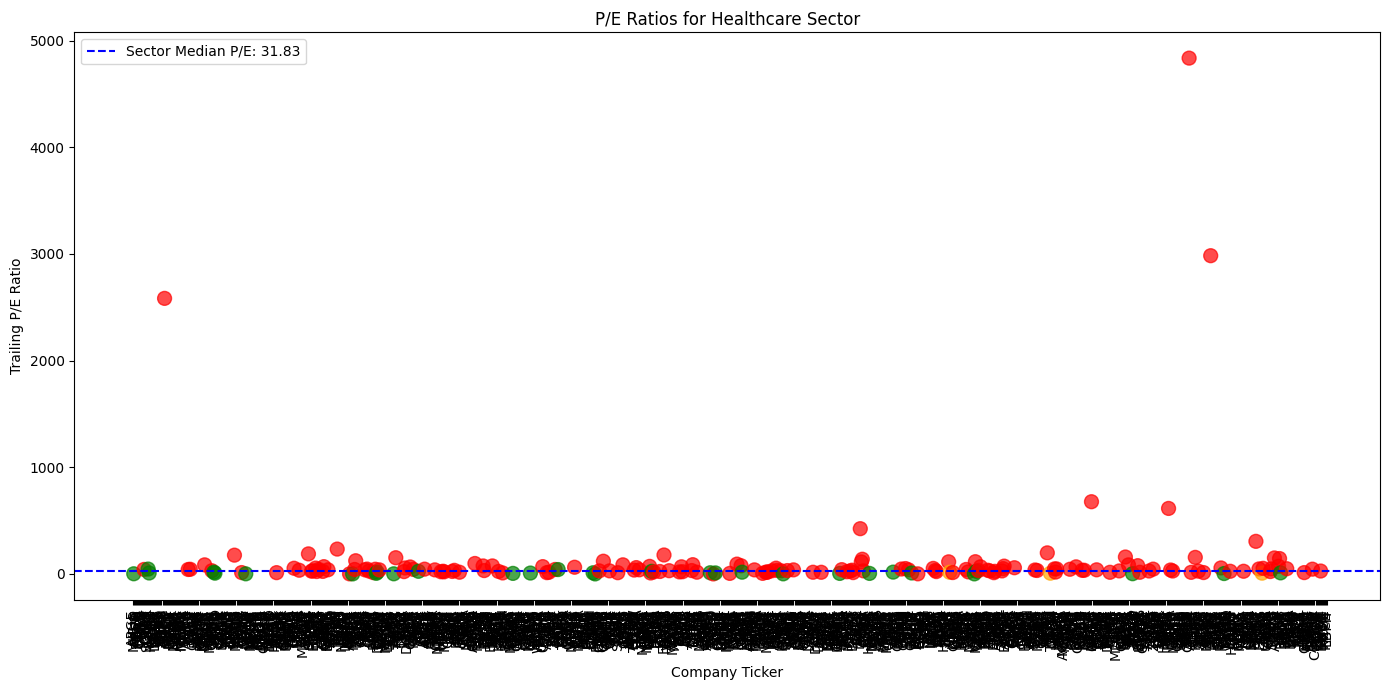

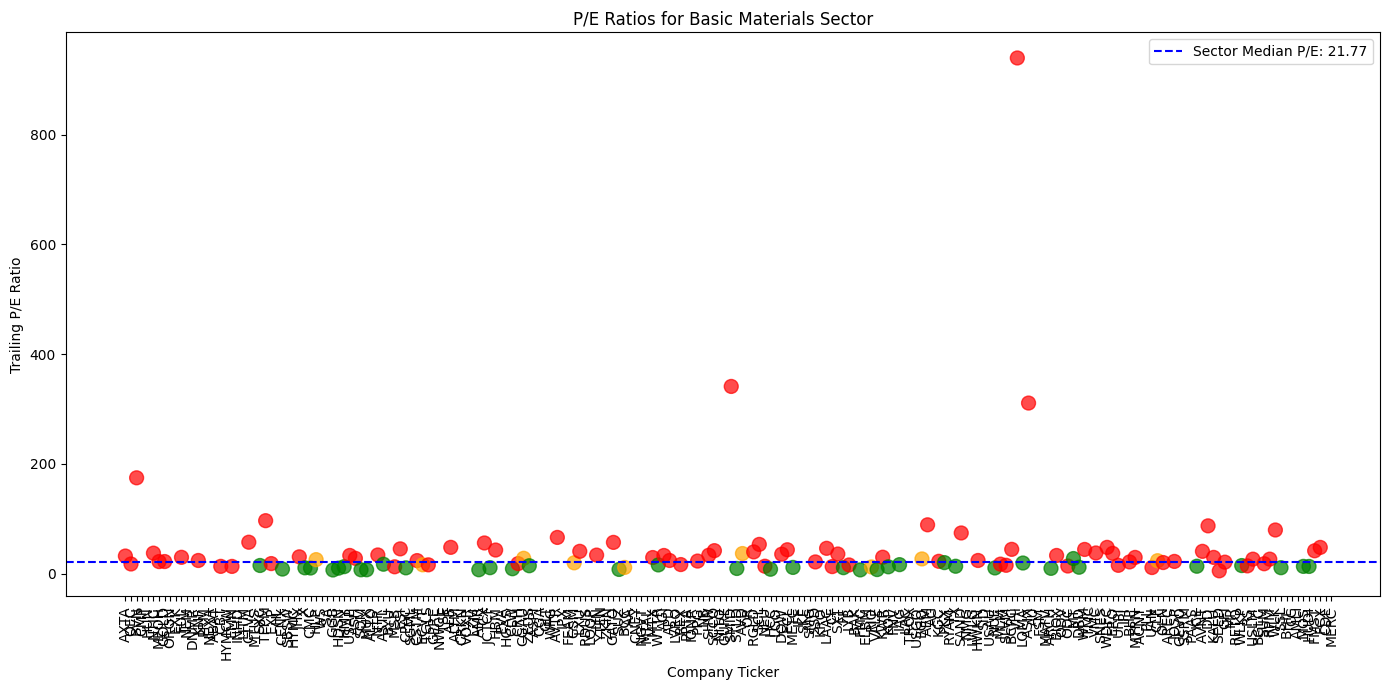

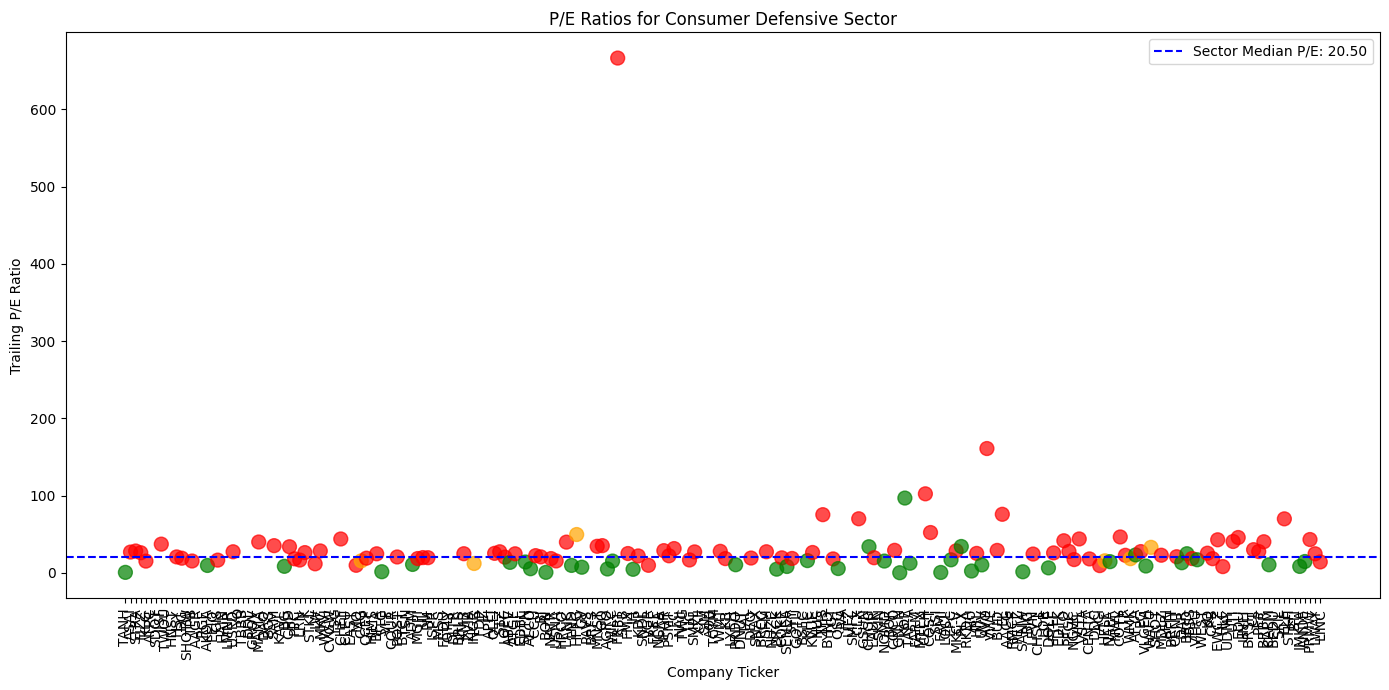

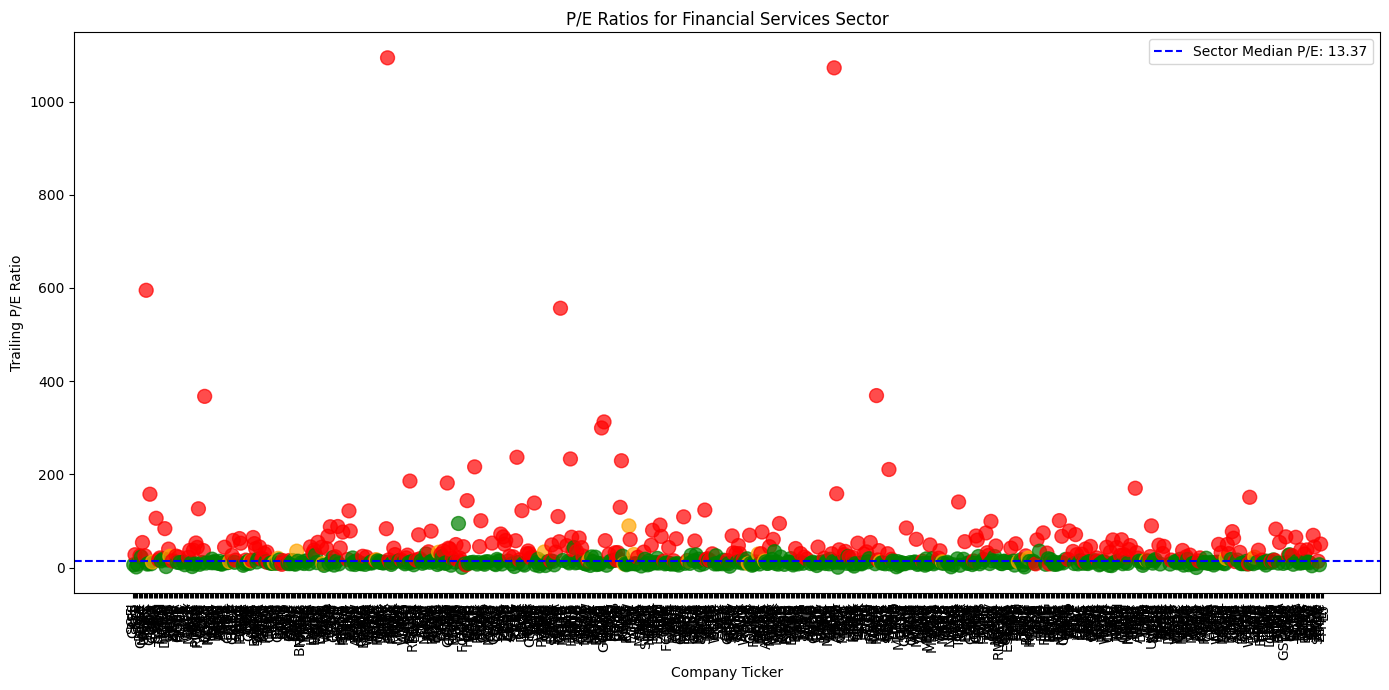

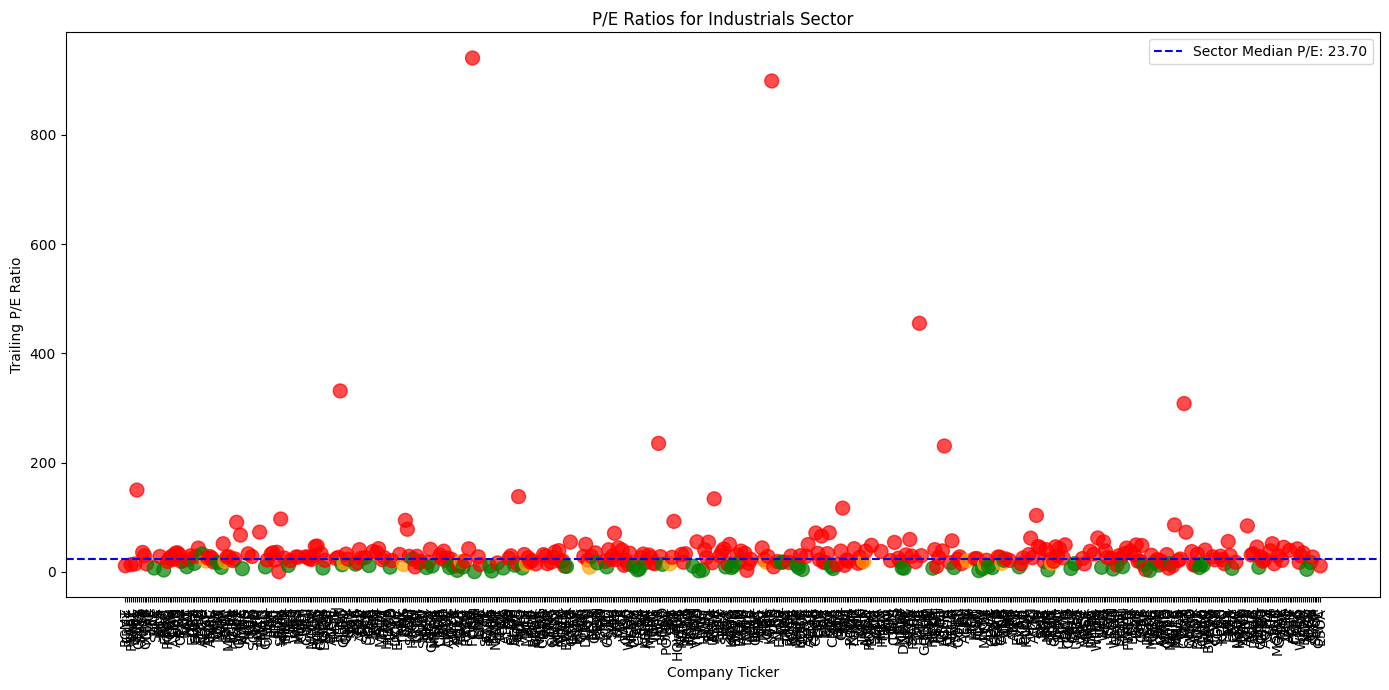

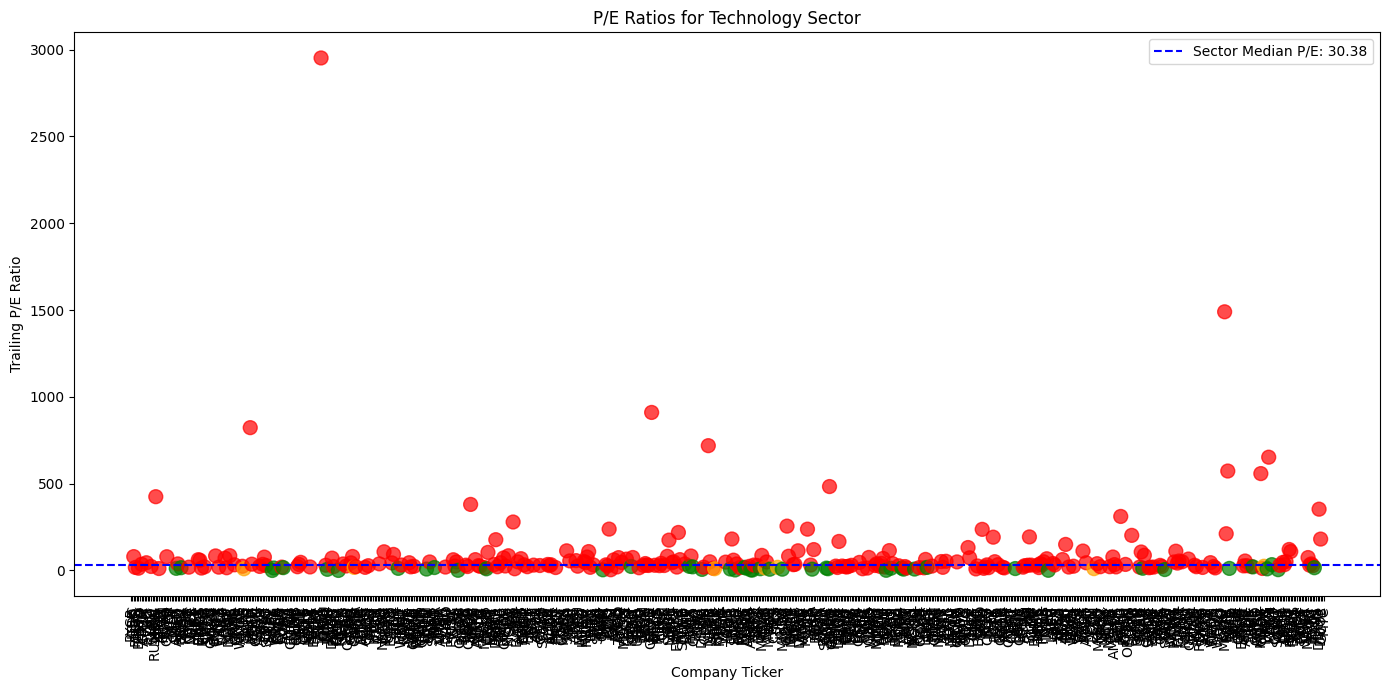

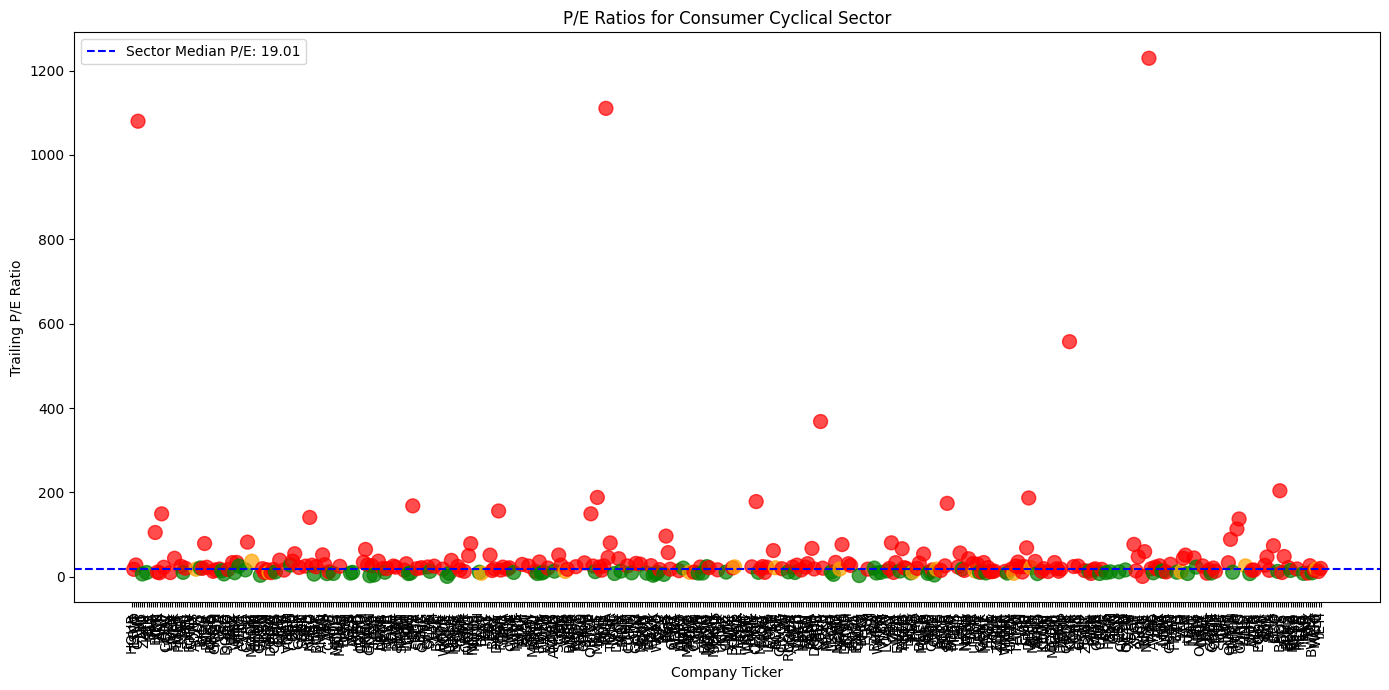

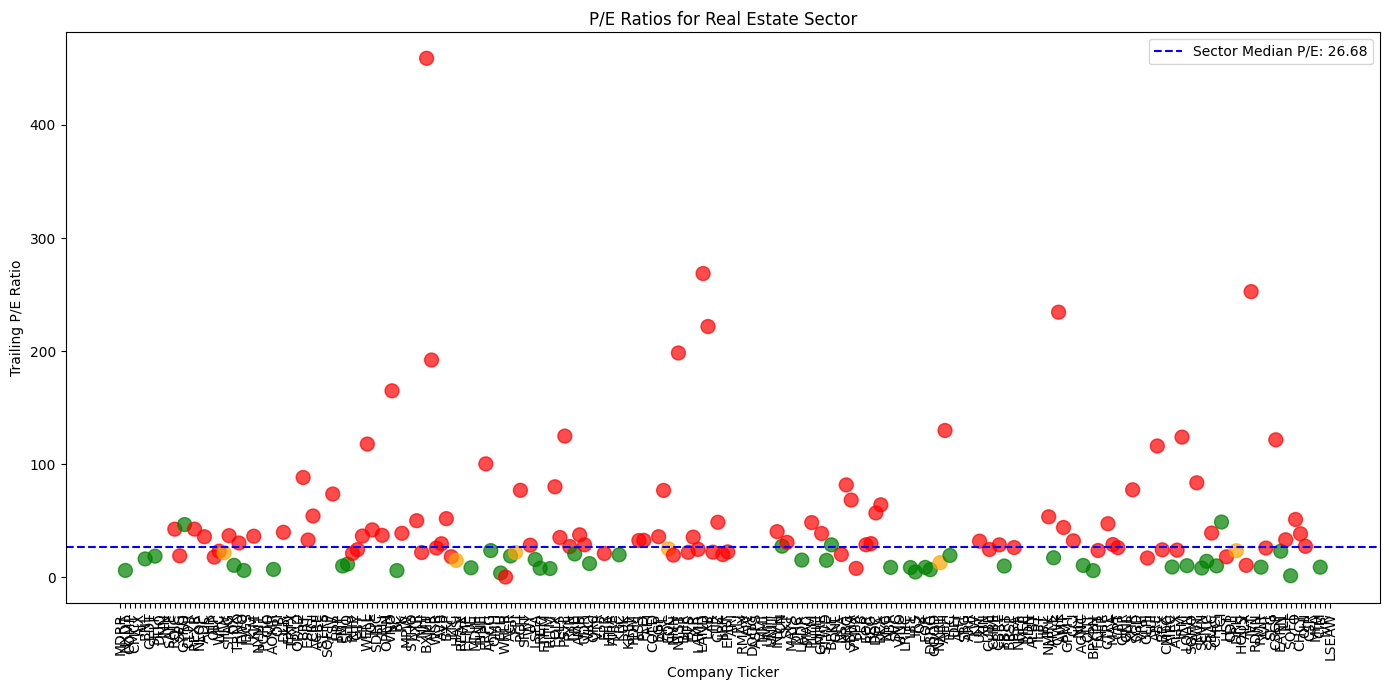

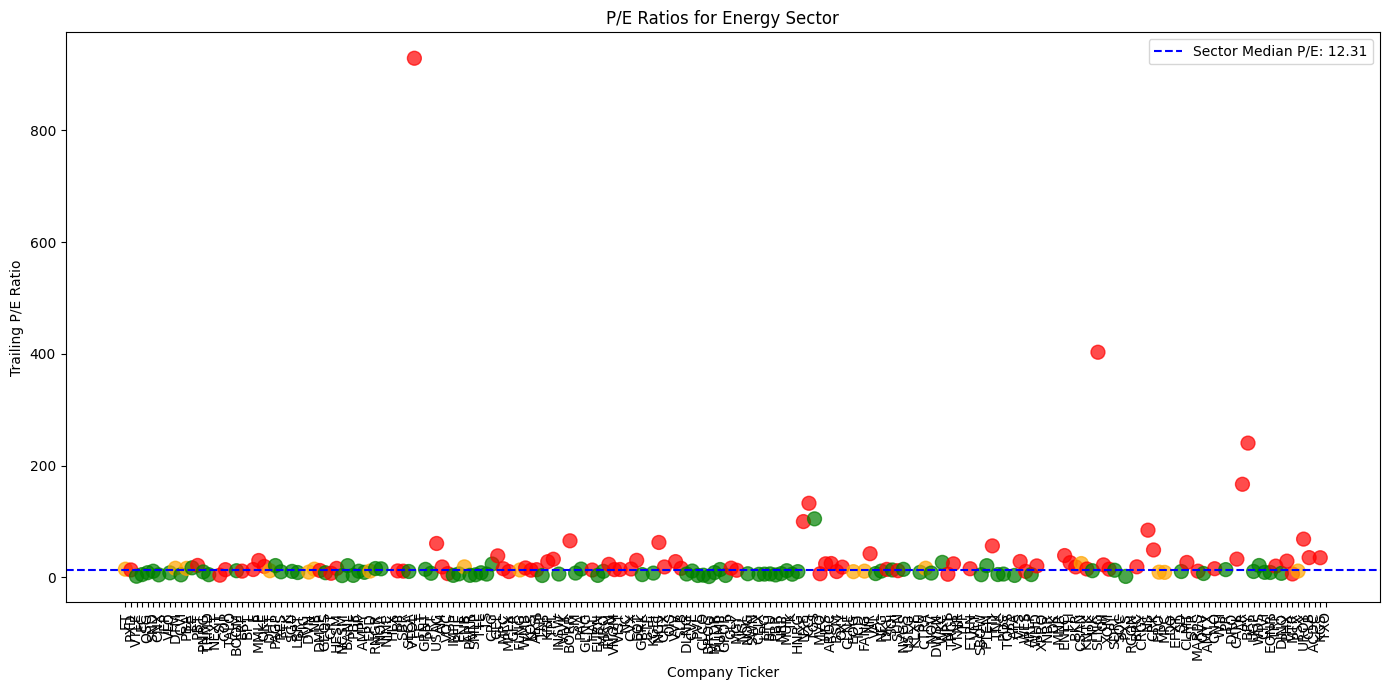

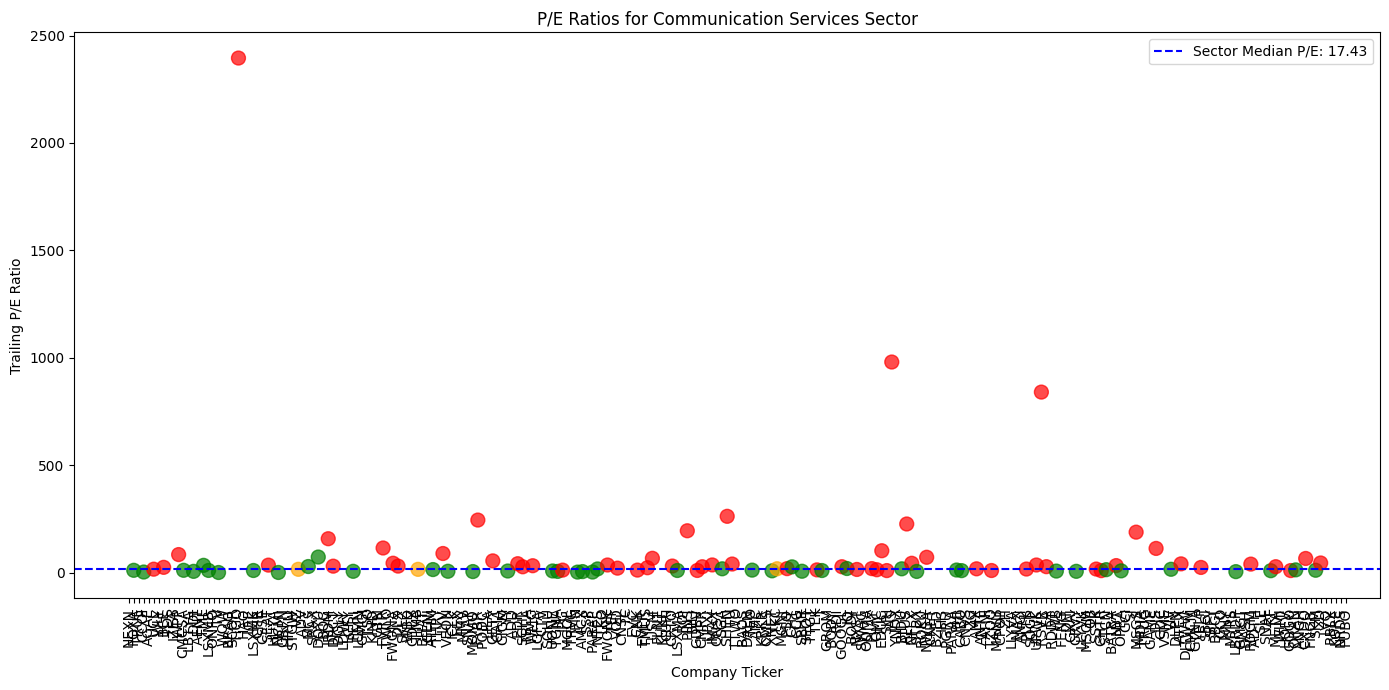

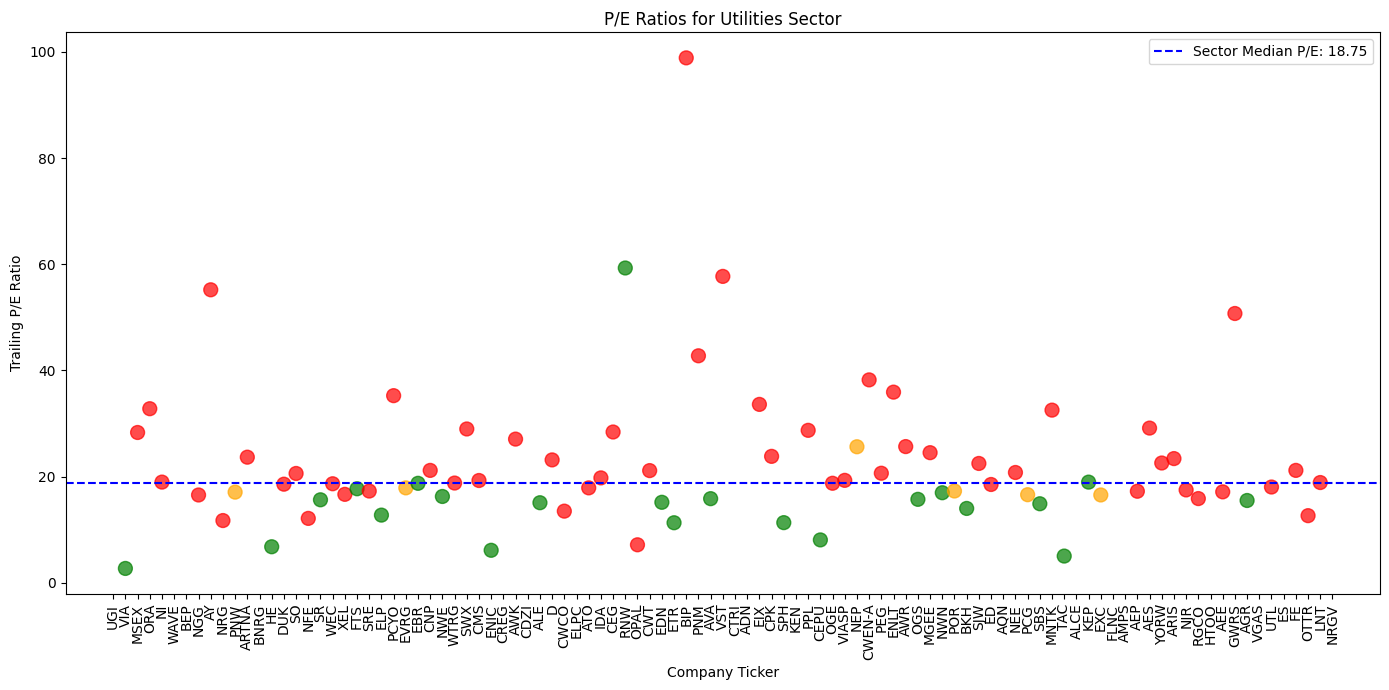

In [20]:
for sector in unique_sectors:
    df_sector_results = sector_results.get(sector, pd.DataFrame())
    plot_pe_ratios(df_sector_results, sector)

In [21]:
import numpy as np

def plot_pe_pb_with_marketcap(df):
    # Ensure Market Cap is in a suitable scale (e.g., billions) and convert to a size for the plot
    df['MarketCap_Billions'] = df['Market Cap'] / 1e9
    sizes = df['MarketCap_Billions'] * 10  # Scale market cap sizes for visibility

    # Create the scatter plot
    plt.figure(figsize=(14, 8))
    plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')
    
    # Loop through the DataFrame and add ticker symbols as text labels for each bubble
    for i, row in df.iterrows():
        # Check if both PB_Ratio and Trailing P/E are finite numbers
        if np.isfinite(row['P/B Ratio']) and np.isfinite(row['Trailing P/E']):
            plt.text(row['P/B Ratio'], row['Trailing P/E'], row['Ticker'], 
                     ha='center', va='center', fontsize=8, color='black', alpha=0.7)
    
    plt.title('P/B Ratio vs. Trailing P/E with Market Cap Size Indicator')
    plt.xlabel('P/B Ratio')
    plt.ylabel('Trailing P/E Ratio')
    plt.xscale('log')  # Using log scale for P/B Ratio if wide range values are expected
    plt.yscale('log')  # Using log scale for P/E Ratio to handle wide range of values and outliers

    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [22]:
'''
******
Use this if you want to plot all the data in one figure, but it gets quite messy
******

# Initialize an empty DataFrame
all_sectors_df = pd.DataFrame()

for sector, df in sector_results_dict.items():
    # Optionally, add a sector column to each sector's DataFrame before concatenation
    df['Sector'] = sector
    # Concatenate the current sector's DataFrame to the comprehensive DataFrame
    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)
'''

"\n******\nUse this if you want to plot all the data in one figure, but it gets quite messy\n******\n\n# Initialize an empty DataFrame\nall_sectors_df = pd.DataFrame()\n\nfor sector, df in sector_results_dict.items():\n    # Optionally, add a sector column to each sector's DataFrame before concatenation\n    df['Sector'] = sector\n    # Concatenate the current sector's DataFrame to the comprehensive DataFrame\n    all_sectors_df = pd.concat([all_sectors_df, df], ignore_index=True)\n"

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


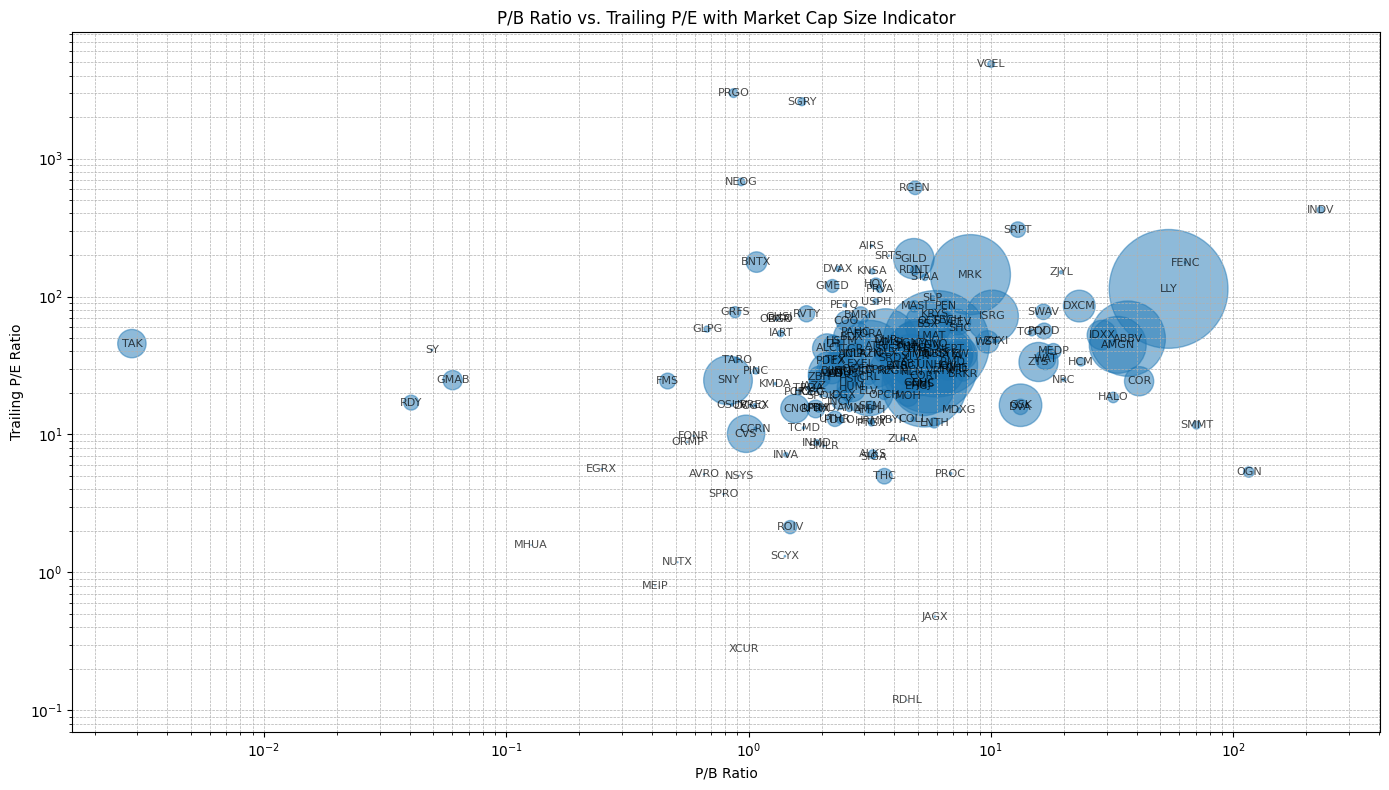

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


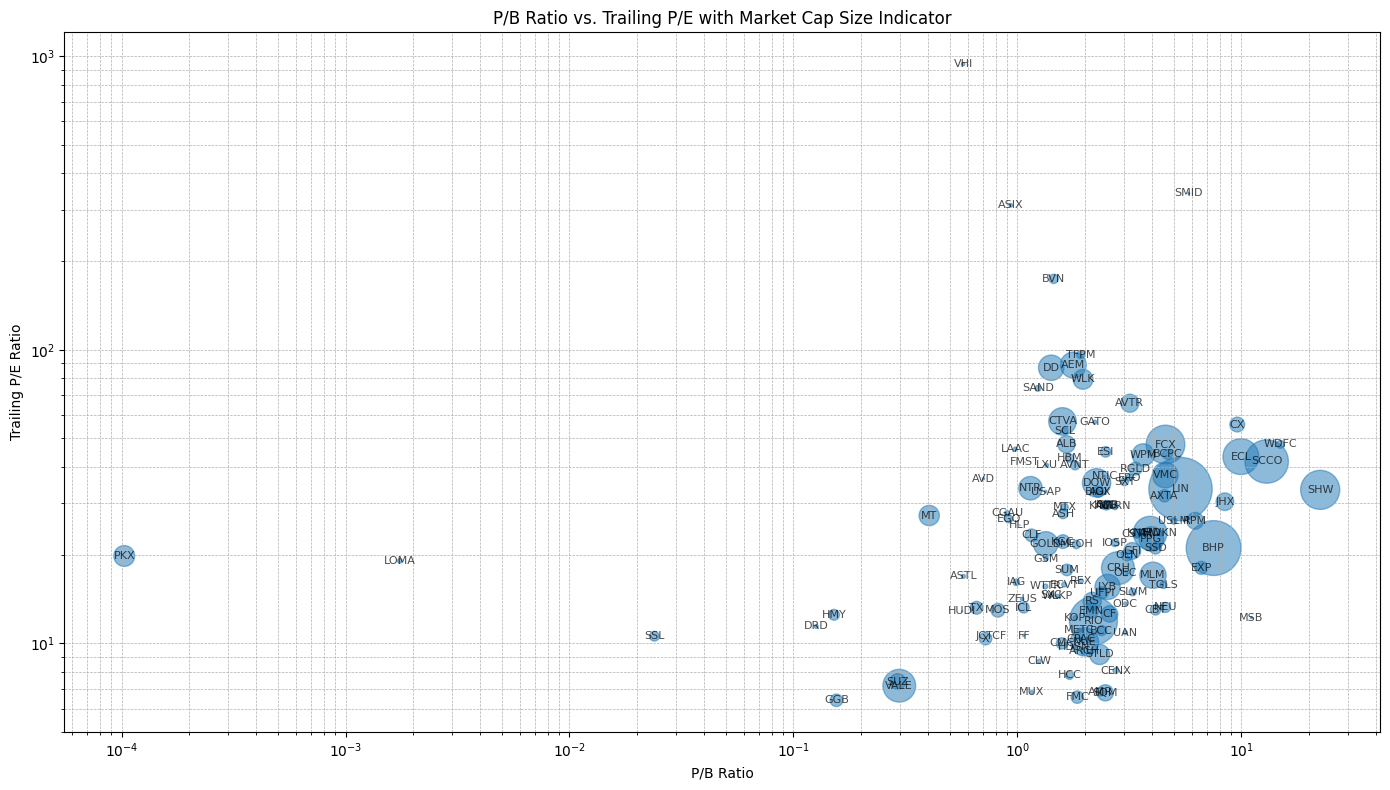

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


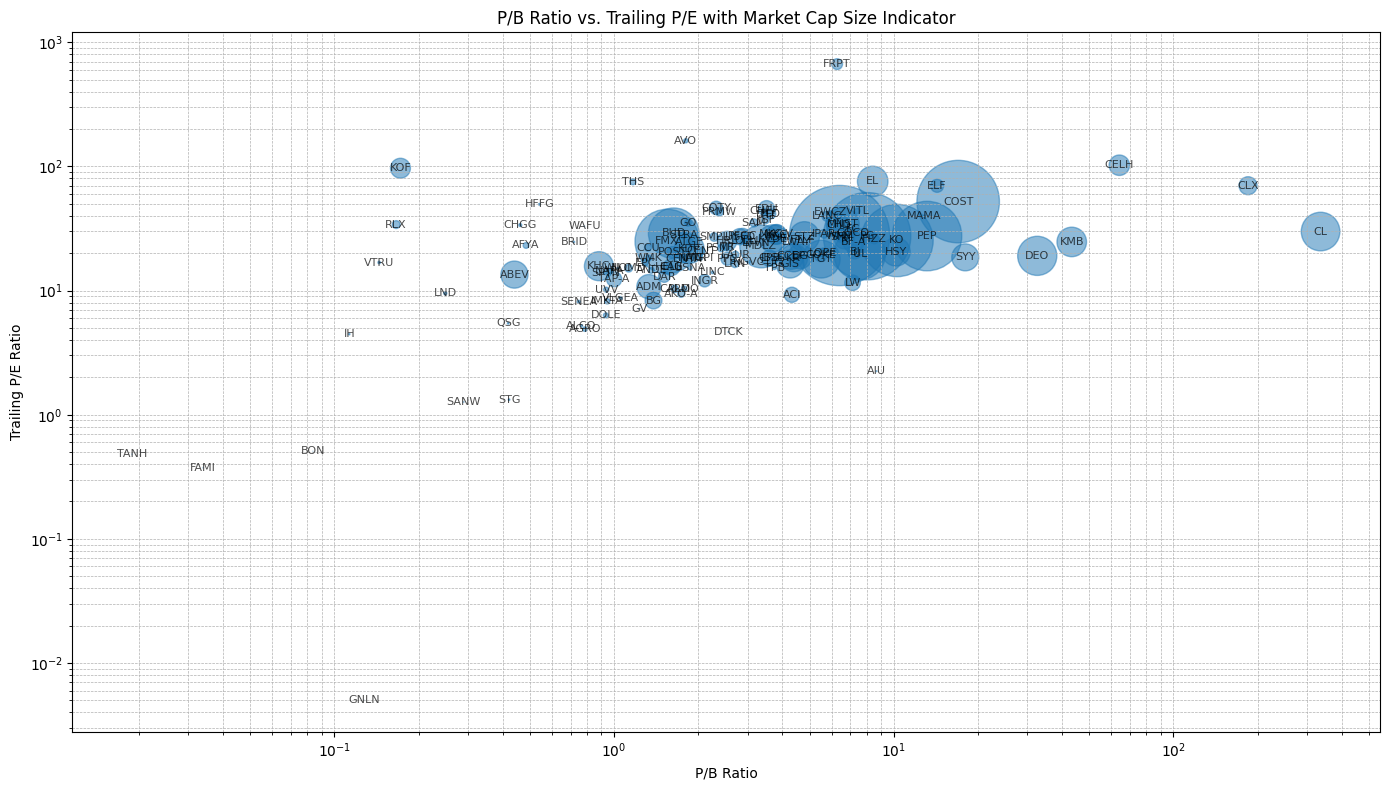

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


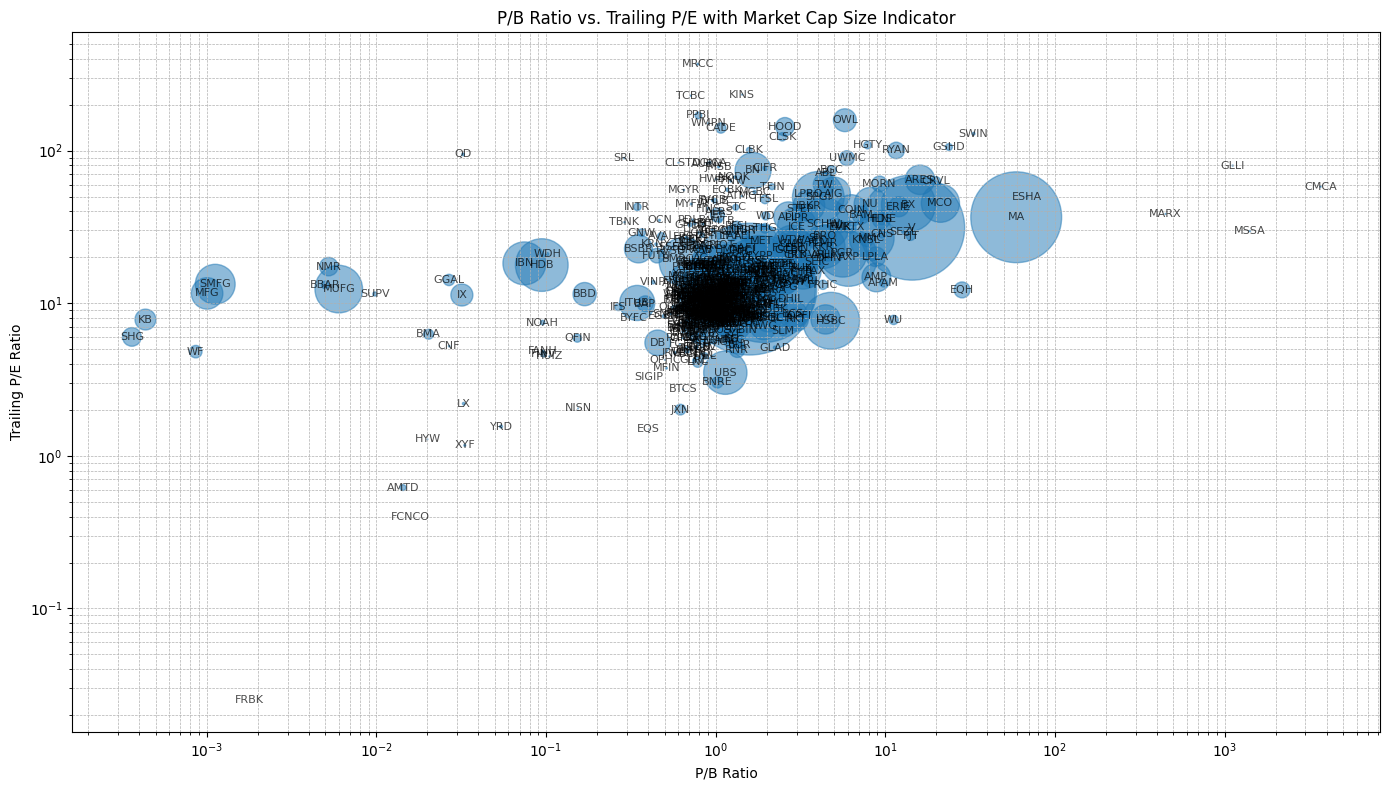

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


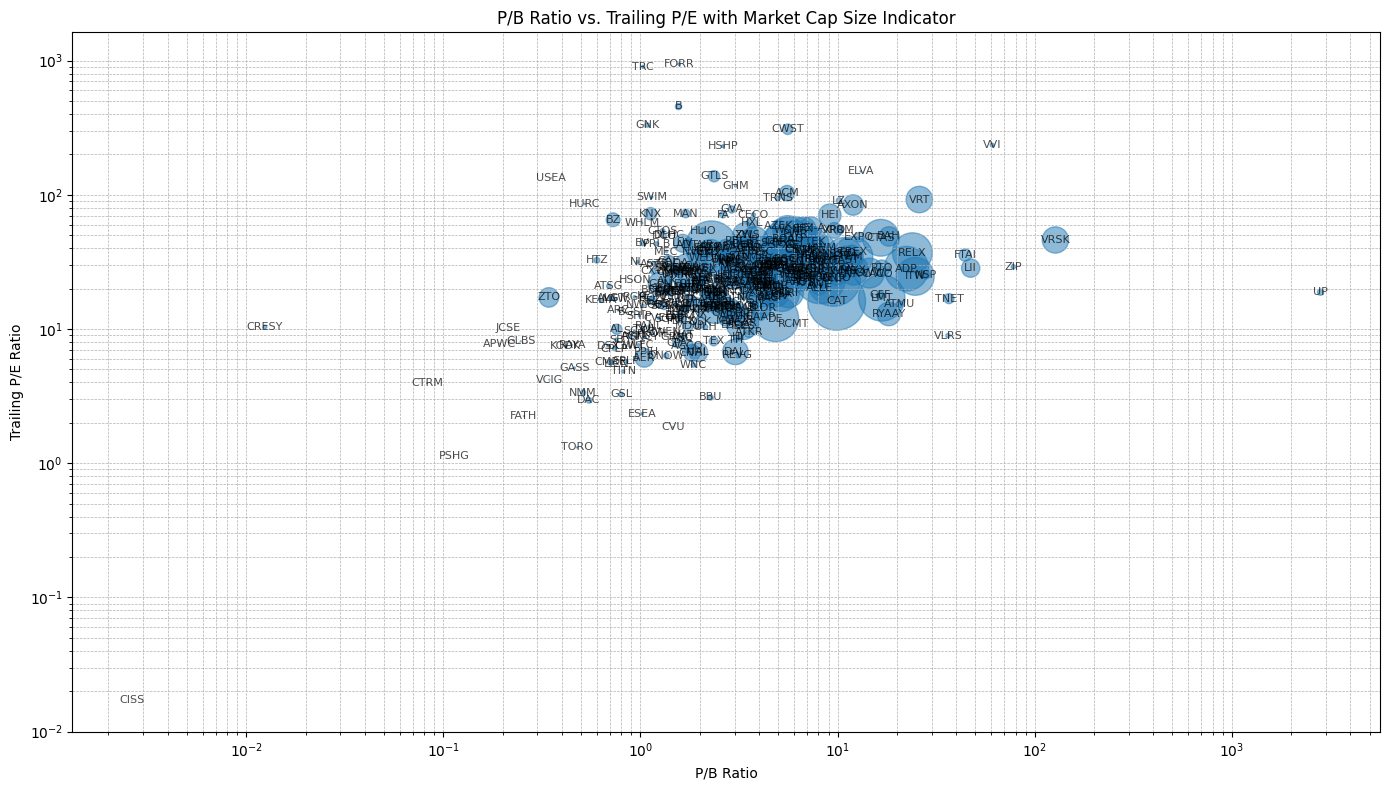

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


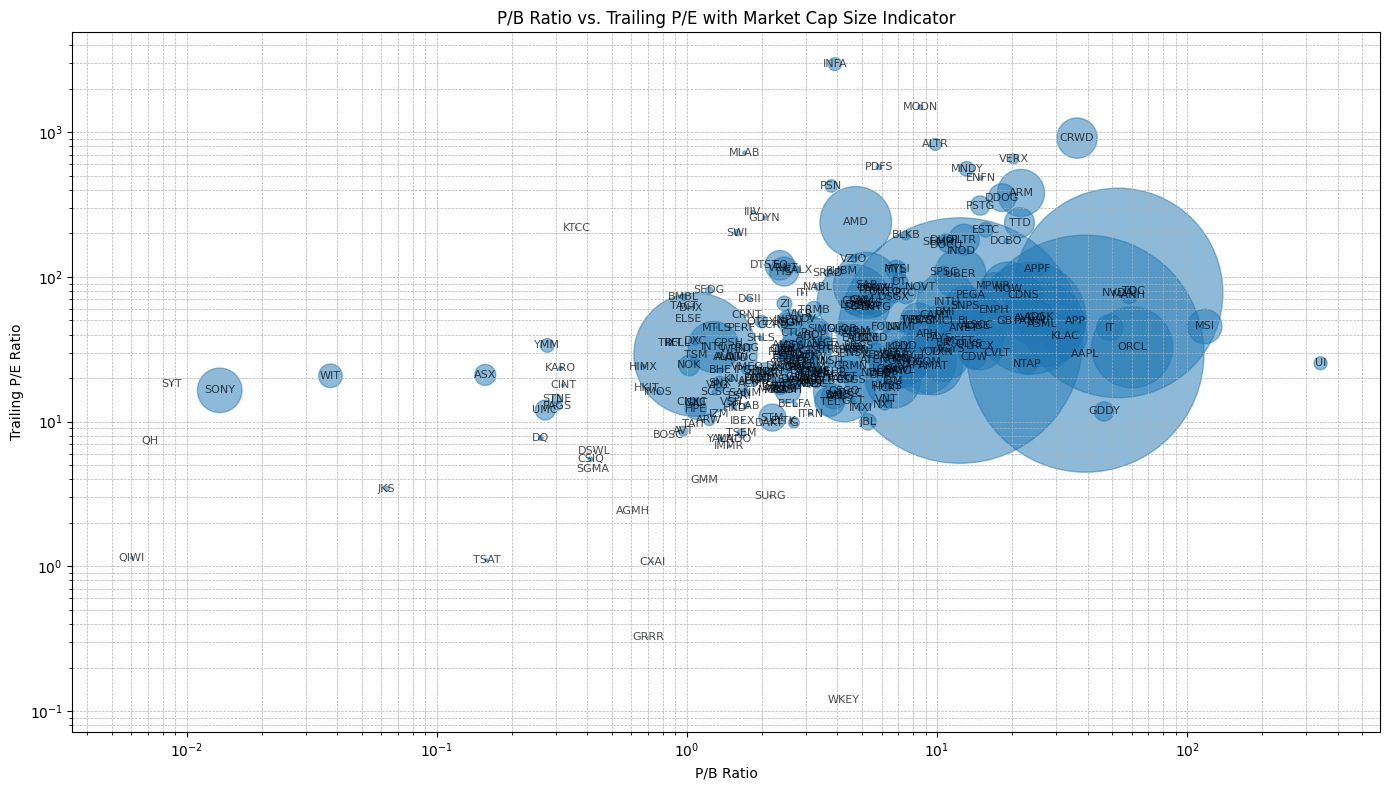

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


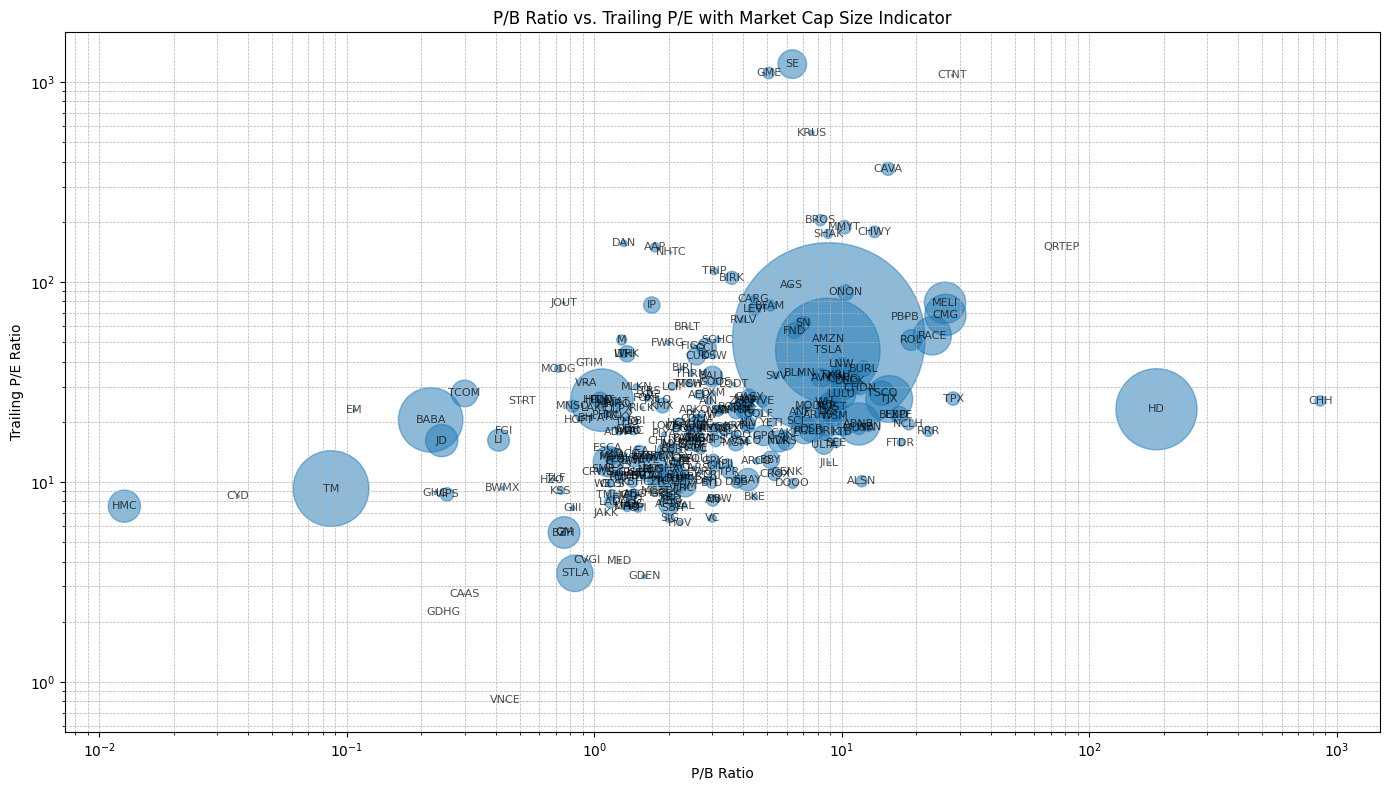

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


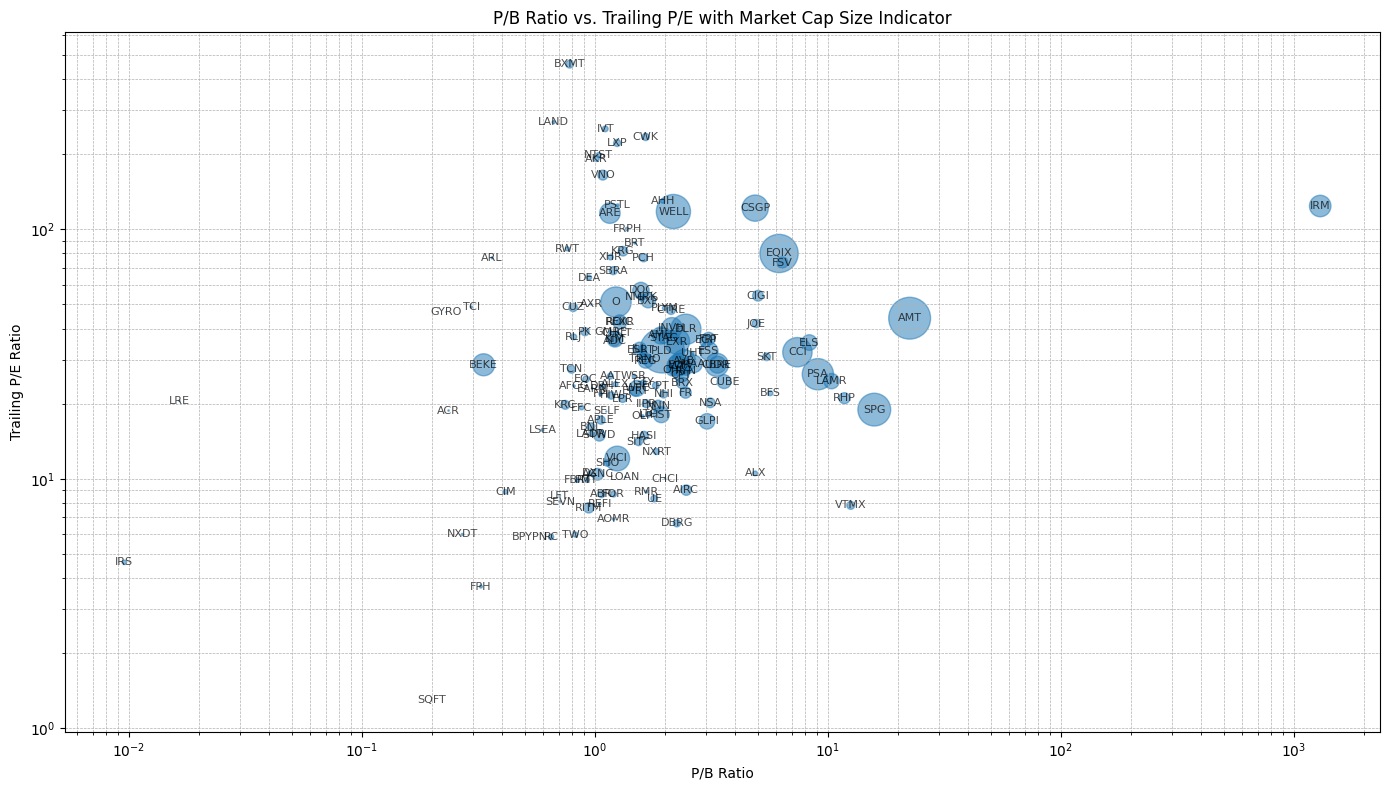

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


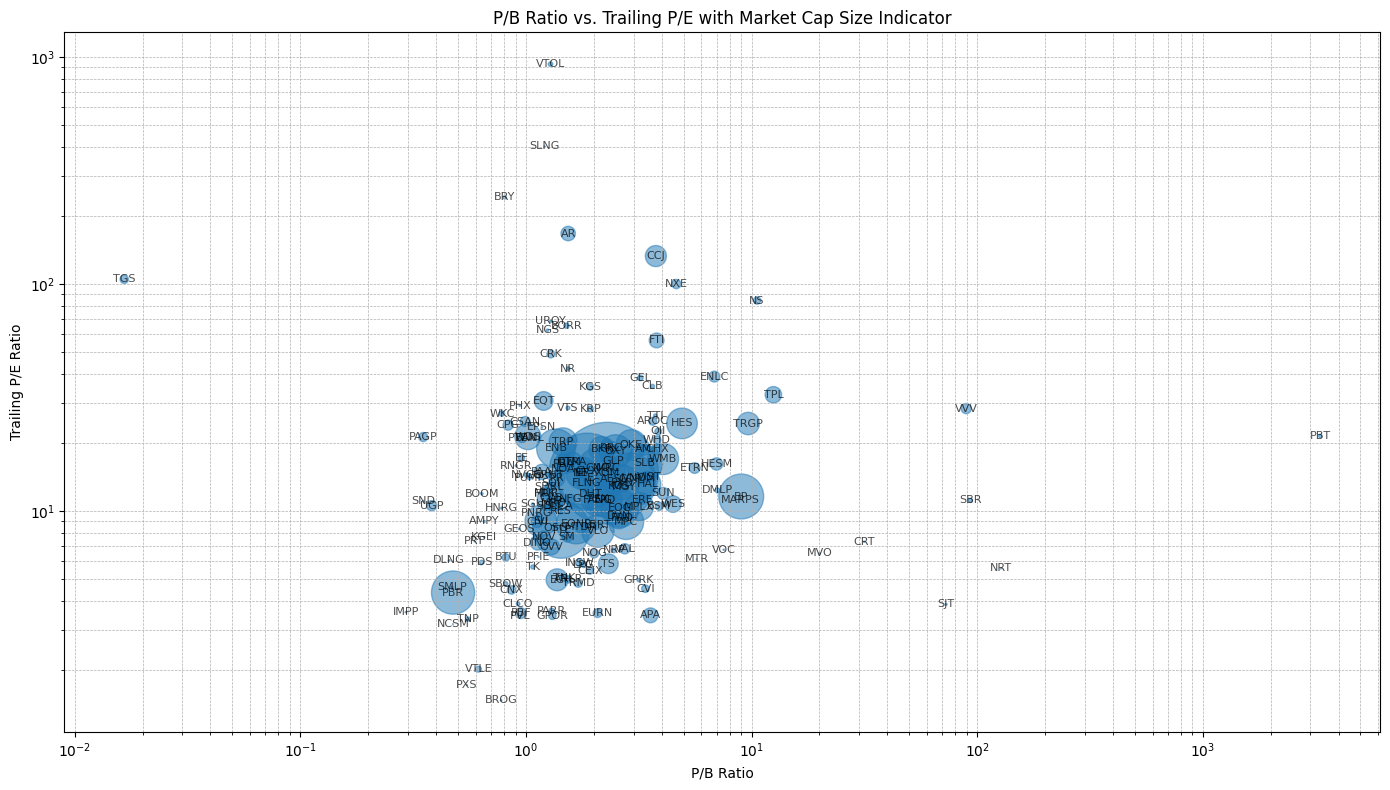

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


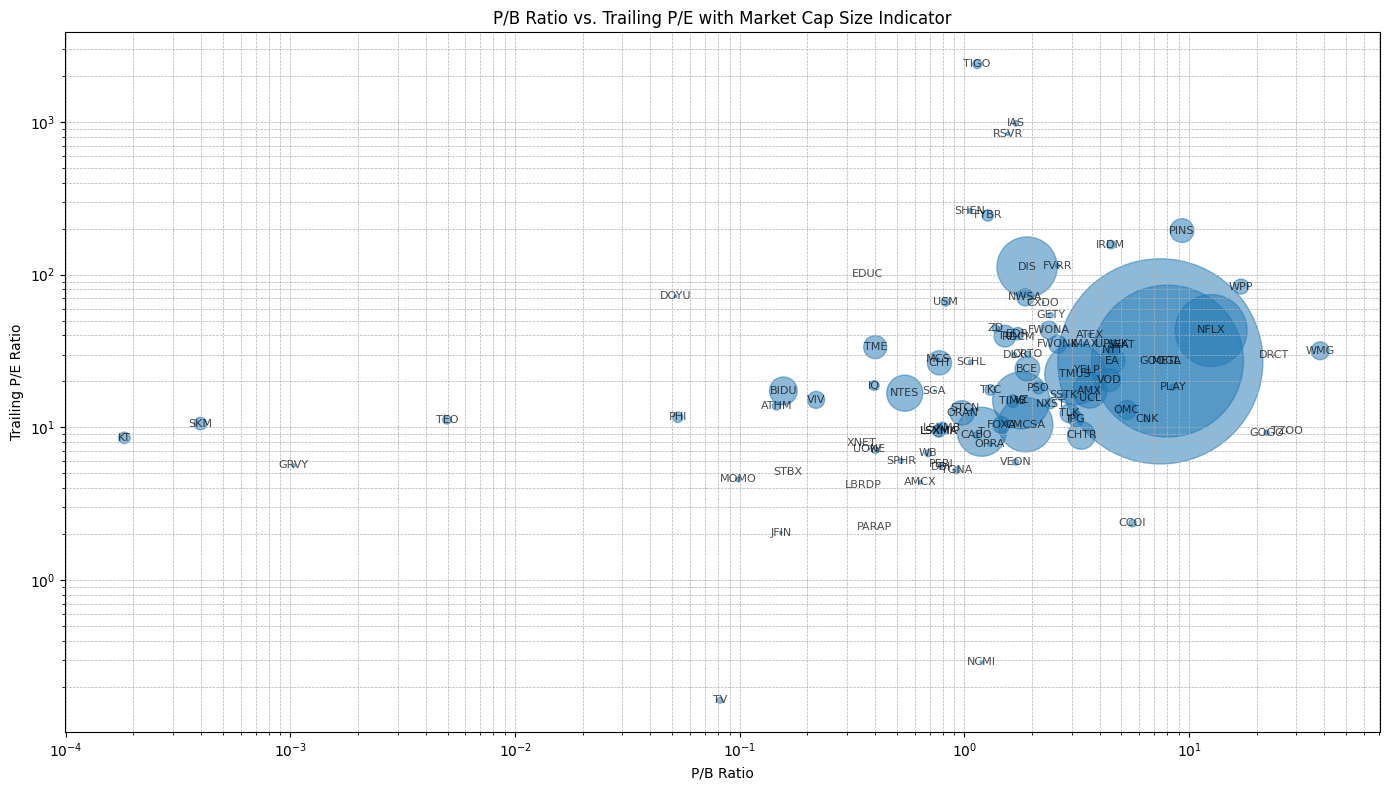

/var/folders/f6/ysbvf32j6ks_1h83gmlfzghw0000gn/T/ipykernel_12876/3310547918.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['P/B Ratio'], df['Trailing P/E'], s=sizes, alpha=0.5, cmap='viridis')


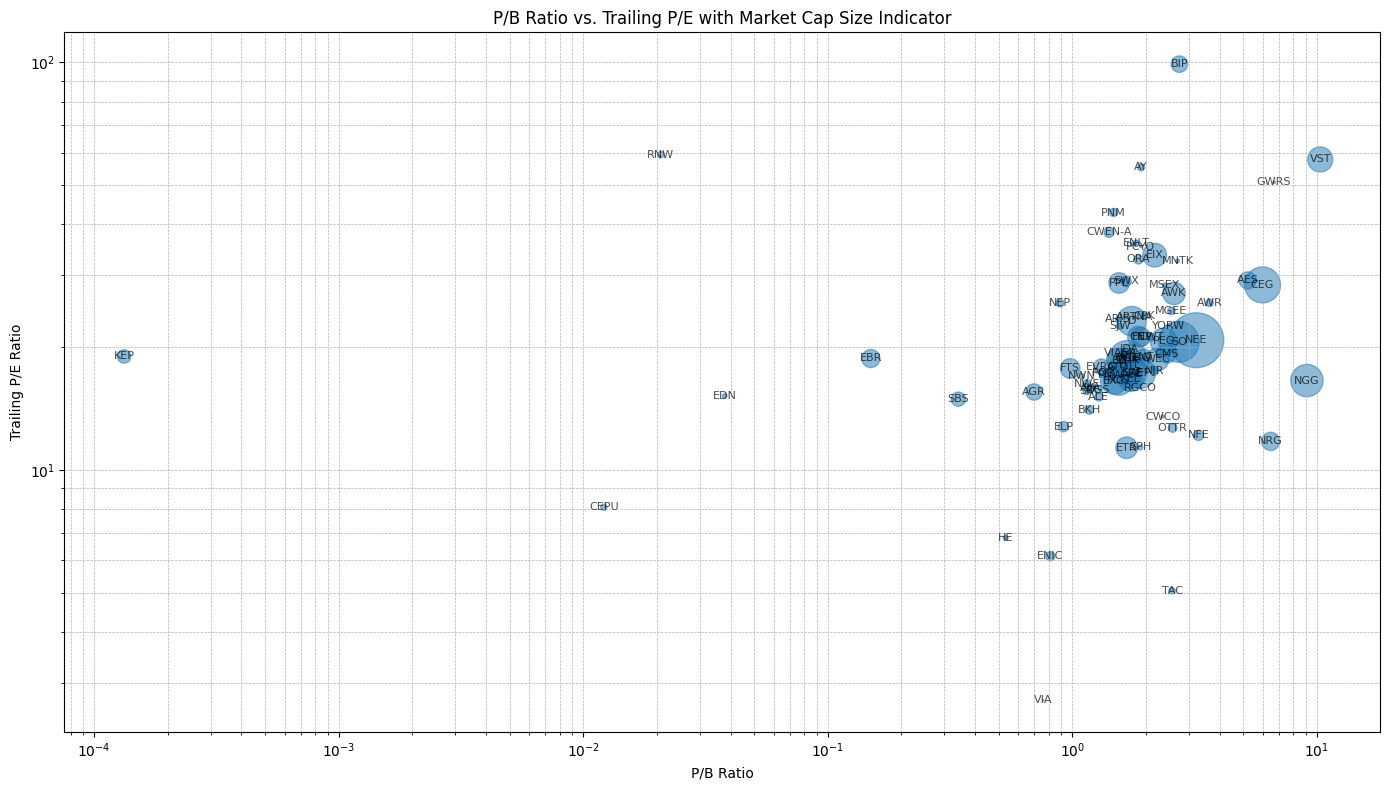

In [23]:
for sector in unique_sectors:
    plot_pe_pb_with_marketcap(sector_results[sector])